In [4]:
from pathlib import Path
from typing import Iterable, Union

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme(style="white")

ROGI_KEY = "rogi"
CSV_DIR = Path("./results/raw/tdc/")

In [2]:
def condense(df: pd.DataFrame) -> pd.DataFrame:
    return df.groupby(["dataset_and_task", "featurizer", "n_valid"])\
        .agg({ROGI_KEY: ['mean', 'std']})\
        .reset_index()


def disable_gridlines(ax: plt.Axes, axis: str, vals: Union[float, Iterable[float]]):
    if isinstance(vals, float):
        vals = [vals]

    vals = set(vals)
    gridlines = ax.get_xgridlines() if axis == "x" else ax.get_ygridlines()

    for line in gridlines:
        val = line.get_xdata()[0] if axis == "x" else line.get_ydata()[0]
        if val in vals:
            line.set_visible(False)
    
    return ax

In [5]:
dfs = map(pd.read_csv, CSV_DIR.iterdir())
df = pd.concat(
    [condense(df) for df in dfs], ignore_index=True
).set_index(['dataset_and_task', 'featurizer'])

df

n_valid      rogi     
                                                mean  std
dataset_and_task        featurizer                       
AMLODIPINE_MPO          chemgpt      10000  0.349924  0.0
ARIPIPRAZOLE_SIMILARITY chemgpt      10000  0.207323  0.0
CACO2_WANG              chemgpt        910  0.279063  0.0
CELECOXIB_REDISCOVERY   chemgpt      10000  0.229942  0.0
CLEARANCE_HEPATOCYTE_AZ chemgpt       1213  0.549210  0.0
...                                    ...       ...  ...
SCAFFOLD HOP            chemberta    10000  0.258352  0.0
SOLUBILITY_AQSOLDB      chemberta     9982  0.249852  0.0
VALSARTAN_SMARTS        chemberta    10000  0.018165  0.0
VDSS_LOMBARDO           chemberta     1130  0.050939  0.0
ZALEPLON_MPO            chemberta    10000  0.359780  0.0

[130 rows x 3 columns]

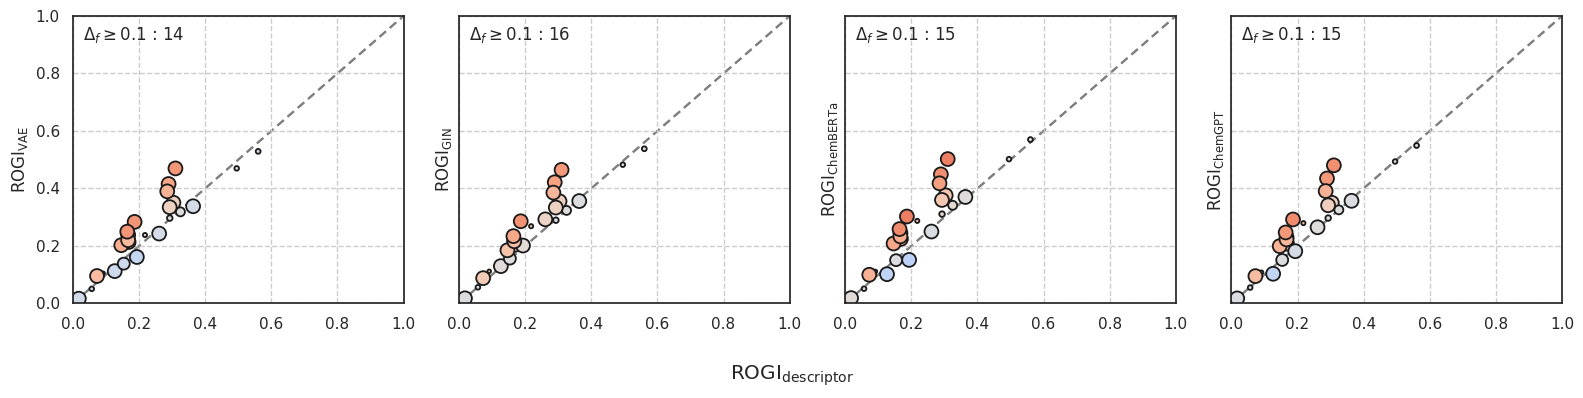

In [23]:
def rogi_string(x: str):
    return rf"$\mathrm{{ROGI}}_{{\mathrm{{{x}}}}}$"

def parity_plot(
    ax: plt.Axes, df: pd.DataFrame, x_key: str, y_key: str, threshold: float = 0.1
):
    BUFFER = 0.03

    x = df.xs(x_key.lower(), level=1)[ROGI_KEY]['mean'].values
    y = df.xs(y_key.lower(), level=1)[ROGI_KEY]['mean'].values
    s = (df.groupby('dataset_and_task')["n_valid"].mean().values) / 1e2
    z = (y - x) / x

    ax.scatter(x, y, s, z, vmin=-1, vmax=1, cmap="coolwarm", edgecolors='k', lw=1.3)

    ax.plot([[0, 0], [1, 1]], '--', c='grey', dashes=(4, 2.5), zorder=-1)

    # val = f"{rogi_string(y_key)} > {rogi_string(x_key)}"
    N = (z > threshold).sum()
    s = rf"$\Delta_f \geq {threshold}$ : {N}"
    ax.text(
        0 + BUFFER, 1 - BUFFER, s, fontsize=12,
        transform=ax.transAxes, ha="left", va="top"
    )
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(axis="both", ls="--")

    ax.set_ylabel(rogi_string(y_key))


X_KEY = "descriptor"
Y_KEYS = ["VAE", "GIN", "ChemBERTa", "ChemGPT"]
N = len(Y_KEYS)

fig, axs = plt.subplots(1, N, figsize=(4 * N, 4), sharex=True, sharey=True)

for ax, y_key in zip(axs, Y_KEYS):
    parity_plot(ax, df, X_KEY, y_key)

fig.supxlabel(rogi_string(X_KEY))
fig.tight_layout()

In [4]:
fig.savefig("./results/figures/vae-gin-bert-gpt.pdf", bbox_inches="tight")

In [24]:
def boxplot(ax: plt.Axes, df, x_key, y_keys, threshold: float = 0.1):
    LINE_WIDTH = 1.5
    BUFFER = 0.02

    x = df.xs(x_key, level=1)[ROGI_KEY]['mean'].values
    ys = [df.xs(k.lower(), level=1)[ROGI_KEY]['mean'].values for k in y_keys]
    Z = np.array(ys) / x - 1
    
    props = dict(
        boxprops=dict(fc="b", lw=LINE_WIDTH),
        whiskerprops=dict(lw=LINE_WIDTH),
        capprops=dict(lw=LINE_WIDTH),
        meanprops=dict(marker='^', mfc='w', mec='k'),
        medianprops=dict(ls='--', c='w'),
    )

    _ = ax.boxplot(
        Z.T,
        vert=False,
        labels=y_keys,
        widths=0.5,
        showmeans=True,
        patch_artist=True,
        **props
    )

    ax.grid(which="both", axis="x", ls="--", dashes=(4, 4))
    ax.axvline(0, ls="--", color="r", dashes=(5, 4))

    for j, z in enumerate(Z):
        s = rf"$f\geq{threshold}$ = {(z > threshold).sum()}/{len(z)}"
        ax.text(
            1 + BUFFER, j+1, s, fontsize=10,
            ha="right", va="center"
        )

    rogi_string = lambda s : rf"$\mathrm{{ROGI}}_{{\mathrm{{{s}}}}}$"
    ax.set_xlabel(f"Fractional difference betweeen {rogi_string('*')} and {rogi_string('desc')}")

    return ax

<AxesSubplot: xlabel='Fractional difference betweeen $\\mathrm{ROGI}_{\\mathrm{*}}$ and $\\mathrm{ROGI}_{\\mathrm{desc}}$'>

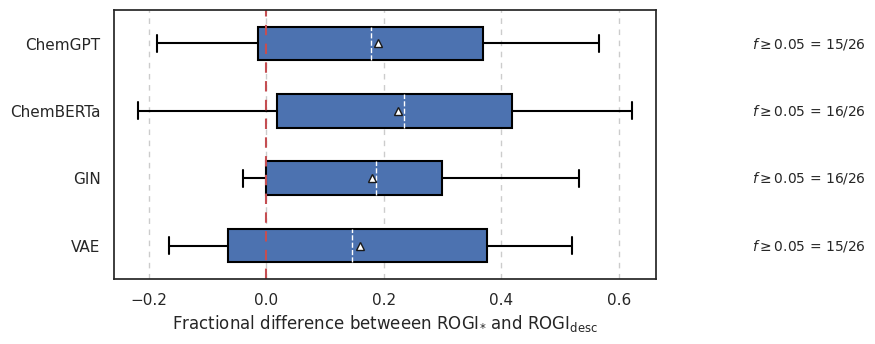

In [28]:
sns.set_palette("deep", color_codes=True)

Y_KEYS = ["VAE", "GIN", "ChemBERTa", "ChemGPT"]
fig, ax = plt.subplots(1, 1, figsize=(7, len(Y_KEYS) * 0.875))
boxplot(ax, df, "descriptor", Y_KEYS, 0.05)

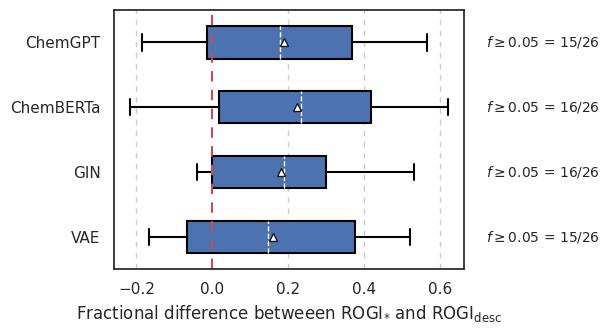

In [29]:
disable_gridlines(ax, "x", [0])
fig.tight_layout()
fig

In [10]:
fig.savefig("./results/figures/boxplot.pdf", bbox_inches="tight")